# 프로젝트 폐렴 진단기 성능 개선

좀전까지 우리는 대략 80% 정도의 정확도를 가진 X-RAY 사진 판독 폐렴 진단기를 만들어 보았습니다.

하지만 숙련된 의사분들은 90% 이상에 도달한다고 하니, 좀더 분발해야겠죠?

그렇다면 우리는 좀전까지의 실습 과정을 되짚어보면서, 어떤 점을 좀더 개선해볼 수 있을지 따져 보고 스스로 개선해 가면서 좀더 성능을 향상시켜 보려고 합니다.

In [1]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

---

# Step 1. 실험환경 Set-up

거의 바꿔볼 수 있을게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다.

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [300, 300]

# EPOCH 크기 변수
EPOCHS = 25

print(ROOT_PATH)

/home/aiffel-dj24/aiffel


___

# Step 2. 데이터 준비하기

원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다.
의료영상 이미지의 특성상 데이터는 언제나 충분하지 않습니다. 이를 극복할 수 있는 방법을 고민해 봅시다.

이전 실습에서 고려하지 않았던 augmentation 기법을 고려해 볼 수 있을 것입니다. 그러나 의료영상인 경우, 일반적인 이미지처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다. 특히 X-RAY 같은 의료영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다.
그래서 augmentation 도입은 신중해야 합니다.

만약 예를 들어 좌우반전 정도의 augmentation만 도입한다고 한다면 다음과 같이 진행될 것입니다.

## 데이터 가져오기

In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


## 데이터 비율 조정

- train 5216개(89%), test 624개(10.7%), val 16개(0.3%)
- val 데이터가 너무 없기 때문에 train에서 val에 쓰일 데이터를 보충
- train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할

In [4]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


## train 데이터 확인

In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1092
Pneumonia images count in training set: 3093


## tf.data 인스턴스 생성

In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

## train, validation 데이터셋 갯수 확인

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


## 라벨 확인

In [8]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['PNEUMONIA' 'NORMAL']


## 라벨 생성 함수 구현

In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   
    # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴

## decode_img 함수 구현

- 이미지의 사이즈를 통일
- 효울적인 GPU 메모리 사용을 위한 이미지 축소

In [10]:
def decode_img(img):
  # 이미지를 uint8 tensor로 변경
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입 변경
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정
  return tf.image.resize(img, IMAGE_SIZE)

## process_path 함수 구현

- decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경
- get_label을 이용해서 라벨 값 호출

In [11]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

## train, validation 데이터 셋 생성

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

## 이미지 리사이즈 및 라벨 입력 확인

In [13]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (300, 300, 3)
Label:  False


##  test 데이터 셋 생성

In [14]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


## augment 함수 구현

In [15]:
def augment(image,label):
    # 랜덤하게 좌우를 반전
    image = tf.image.random_flip_left_right(image)
    return image,label

## prepare_for_training() 함수 구현

- 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환

In [16]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가
#     ds = ds.map(
#             augment,       # augment 함수 적용
#             num_parallel_calls=2
#         )
    
    # 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # 여러번 데이터셋을 사용하게 해 줌
    ds = ds.repeat()
    # BATCH_SIZE에서 정한 만큼의 배치
    ds = ds.batch(BATCH_SIZE)
    # 학습데이터를 나눠서 읽어와서 GPU 리소스의 유휴 상태를 줄인
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

---

# Step 3. 데이터 시각화

학습용 데이터를 시각화해서 확인해 봅니다.
만약 augmentation을 시도했다면 이후 실습코드에 있는 show_batch() 함수를 통해 실제로 좌우반전 등이 제대로 처리되었는지 확인해 봅시다.

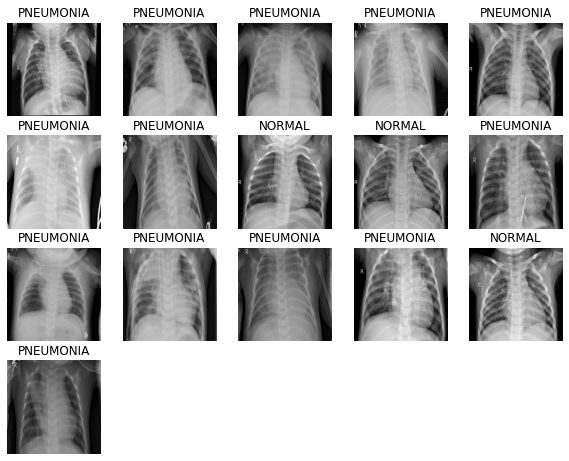

In [17]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

---

# Step 4. CNN 모델링

의료영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다. Convolution filter, 채널 개수, activation, 모델구조 등을 다양하게 바꾸어볼 수 있습니다.

그리고, 우리는 BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 실습했습니다.
이것은 일반적으로 잘 사용되는 형태는 아닙니다. 하지만 이미지 사이즈가 크고 데이터가 부족한 의료영상에서는 실용적으로 간혹 좋은 성능을 보이기도 합니다. 만약 이 구성을 변경해 보면 어떤 효과가 발생하는지도 실험해 봅시다. BatchNormalization을 쓰거나 혹은 쓰지 않거나, Dropout을 쓰거나 혹은 쓰지 않거나 할 수 있습니다. 또, Dropout 비율을 변경해볼 수도 있습니다.

## Convolution block 생성

In [18]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

## Dense Block 생성

In [19]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

## build_model 함수 구현

In [20]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

---

# Step 5. 데이터 imbalance 처리

실습코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었습니다. 만약 이러한 처리를 생략한다면 어떻게 될까요? 또 recall을 강조하기 위해 폐렴데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?

## Weight balancing

In [21]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.92
Weight for class 1: 0.68


# Step 6. 모델 훈련

loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.

## loss 및 optimizer

In [22]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [23]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 300, 300, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 16)      0         
_________________________________________________________________
sequential (Sequential)      (None, 75, 75, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 37, 37, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 18, 18, 128)       27072     
_________________________________________________________________
dropout (Dropout)            (None, 18, 18, 128)      

## 모델 학습

In [24]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 50s 190ms/step - loss: 0.2391 - accuracy: 0.9085 - precision: 0.9734 - recall: 0.9008 - val_loss: 0.7373 - val_accuracy: 0.7538 - val_precision: 0.7538 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 43s 163ms/step - loss: 0.1637 - accuracy: 0.9346 - precision: 0.9782 - recall: 0.9323 - val_loss: 1.0559 - val_accuracy: 0.7567 - val_precision: 0.7567 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 51s 195ms/step - loss: 0.1412 - accuracy: 0.9473 - precision: 0.9838 - recall: 0.9443 - val_loss: 0.0869 - val_accuracy: 0.9760 - val_precision: 0.9872 - val_recall: 0.9809
Epoch 4/25
261/261 [==============================] - 41s 159ms/step - loss: 0.1079 - accuracy: 0.9605 - precision: 0.9890 - recall: 0.9572 - val_loss: 0.1967 - val_accuracy: 0.9067 - val_precision: 0.8919 - val_recall: 0.9975
Epoch 5/25
261/261 [==============================] - 50s 193ms/step - loss: 0.1080 - accura

---

# Step 7. 결과 확인과 시각화

테스트데이터로 훈련된 모델을 평가해 봅시다. 우선은 accuracy를 고려해야겠지만 의료영상 모델의 특성상 recall도 중요합니다. 훈련과정의 history 그래프를 시각화해 보고, 학습 진행양상을 면밀히 분석해 보는 것도 잊지 않도록 합시다.

## precision, recall, accuracy, loss 시각화

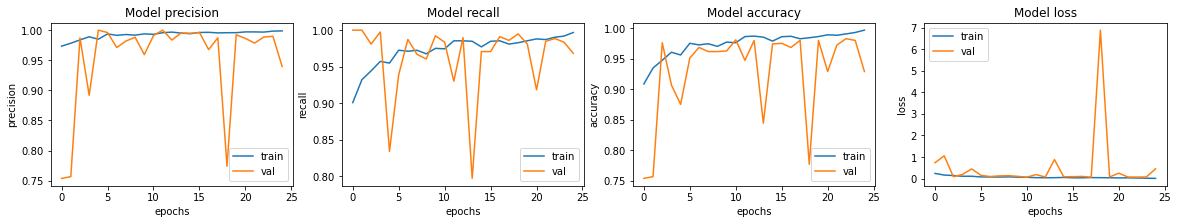

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## 모델 평가

In [26]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 3s 72ms/step - loss: 3.6729 - accuracy: 0.7035 - precision: 0.6808 - recall: 0.9897


---

## 결과 모음

__기본__  
BATCH_SIZE = 16, IMAGE_SIZE = [180, 180], EPOCHS = 25, Conv Block Dropout(0.2)  
loss: 1.3397 - accuracy: 0.7532 - precision: 0.7185 - recall: 0.9949

__1번째 시도__   
IMAGE_SIZE = [500, 500], augment(랜덤 좌우 반전) 사용  
loss: 1.3122 - accuracy: 0.7372 - precision: 0.7062 - recall: 0.9923

__2번째 시도__  
IMAGE_SIZE = [300, 300], EPOCHS = 10, augment(랜덤 좌우 반전) 사용, Dense Block BatchNormalization 미사용  
loss: 15.1210 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000

__3번째 시도__  
IMAGE_SIZE = [300, 300], EPOCHS = 10, augment(랜덤 좌우 반전) 사용, Dense Block Dropout 미사용  
loss: 0.6634 - accuracy: 0.8429 - precision: 0.8067 - recall: 0.9846

__4번째 시도__  
IMAGE_SIZE = [300, 300], EPOCHS = 10, augment(랜덤 좌우 반전) 사용, class_weight 미설정  
loss: 0.9453 - accuracy: 0.7596 - precision: 0.7230 - recall: 0.9974

__5번째 시도__  
BATCH_SIZE = 32, IMAGE_SIZE = [300, 300], EPOCHS = 10, augment(랜덤 좌우 반전) 사용  
loss: 1.0670 - accuracy: 0.7023 - precision: 0.6768 - recall: 1.0000

__6번째 시도__  
BATCH_SIZE = 8, IMAGE_SIZE = [300, 300], EPOCHS = 10, augment(랜덤 좌우 반전) 사용  
loss: 0.5885 - accuracy: 0.7740 - precision: 0.7475 - recall: 0.9641

__7번째 시도__  
IMAGE_SIZE = [300, 300], EPOCHS = 10, Dense Block Dropout 미사용  
loss: 1.0288 - accuracy: 0.8237 - precision: 0.7929 - recall: 0.9718

__8번째 시도__  
IMAGE_SIZE = [300, 300], EPOCHS = 10, Conv Block Dropout(0.5) 적용  
loss: 0.5414 - accuracy: 0.8045 - precision: 0.8073 - recall: 0.9026

__9번째 시도__  
IMAGE_SIZE = [300, 300], EPOCHS = 10, Conv Block과 Dense Block Dropout 미사용  
loss: 1.4580 - accuracy: 0.6987 - precision: 0.6753 - recall: 0.9974

__10번째 시도__  
IMAGE_SIZE = [500, 500], EPOCHS = 15, Dense Block Dropout 미사용  
loss: 1.1688 - accuracy: 0.7660 - precision: 0.7285 - recall: 0.9974

__11번째 시도__  
IMAGE_SIZE = [500, 500], EPOCHS = 15, augment(랜덤 좌우 반전) 사용, Dense Block Dropout 미사용  
loss: 3.4511 - accuracy: 0.6410 - precision: 0.6370 - recall: 0.9897

__12번째 시도__  
IMAGE_SIZE = [200, 200], EPOCHS = 10, augment(랜덤 좌우 반전) 사용, Dense Block Dropout 미사용  
loss: 0.9370 - accuracy: 0.7099 - precision: 0.6830 - recall: 1.0000

__13번째 시도__  
IMAGE_SIZE = [300, 300], EPOCHS = 10, augment(랜덤 좌우 반전) 사용, Conv Block Dropout(0.5) 적용  
loss: 0.4233 - accuracy: 0.8429 - precision: 0.9424 - recall: 0.7974

__14번째 시도__  
IMAGE_SIZE = [400, 400], EPOCHS = 10, augment(랜덤 좌우 반전) 사용, Conv Block Dropout(0.5) 적용  
loss: 0.6381 - accuracy: 0.8317 - precision: 0.8013 - recall: 0.9718

__15번째 시도__  
IMAGE_SIZE = [300, 300], EPOCHS = 10, augment(랜덤 좌우 반전) 사용, Conv Block Dropout(0.5) 적용, Conv Block과 Dense Block BatchNormalization() 미사용  
loss: 0.6924 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000

__16번째 시도__  
IMAGE_SIZE = [350, 350], EPOCHS = 10, augment(랜덤 좌우 반전) 사용, Conv Block Dropout(0.5) 적용  
loss: 0.5611 - accuracy: 0.8093 - precision: 0.8362 - recall: 0.8641

__17번째 시도__  
IMAGE_SIZE = [300, 300], EPOCHS = 20, augment(랜덤 좌우 반전) 사용, Conv Block Dropout(0.5) 적용  
loss: 0.9092 - accuracy: 0.7580 - precision: 0.7242 - recall: 0.9897

__18번째 시도__  
IMAGE_SIZE = [300, 300], EPOCHS = 5, augment(랜덤 좌우 반전) 사용, Conv Block Dropout(0.5) 적용  
loss: 1.2770 - accuracy: 0.7003 - precision: 0.6790 - recall: 0.9872

__19번째 시도__  
IMAGE_SIZE = [300, 300], EPOCHS = 10, augment(랜덤 좌우 반전) 사용  
loss: 1.0138 - accuracy: 0.7420 - precision: 0.7101 - recall: 0.9923

__20번째 시도__  
IMAGE_SIZE = [300, 300], EPOCHS = 10  
loss: 0.7405 - accuracy: 0.7965 - precision: 0.7594 - recall: 0.9872

__21번째 시도__  
IMAGE_SIZE = [300, 300], EPOCHS = 10, augment(랜덤 좌우 반전) 사용, Conv Block Dropout 미사용  
loss: 0.7571 - accuracy: 0.7740 - precision: 0.7380 - recall: 0.9897

__22번째 시도__  
IMAGE_SIZE = [300, 300], EPOCHS = 20, augment(랜덤 좌우 반전) 사용  
loss: 0.9375 - accuracy: 0.7484 - precision: 0.7145 - recall: 0.9949

__23번째 시도__  
IMAGE_SIZE = [300, 300], EPOCHS = 10, augment(랜덤 좌우 반전) 사용, Conv Block Dropout(0.8) 적용  
loss: 1.8581 - accuracy: 0.6346 - precision: 0.6311 - recall: 1.0000

__24번째 시도__(3번째 시도 재반복)  
IMAGE_SIZE = [300, 300], EPOCHS = 10, augment(랜덤 좌우 반전) 사용, Dense Block Dropout 미사용  
loss: 0.8036 - accuracy: 0.7917 - precision: 0.7549 - recall: 0.9872

__25번째 시도__  
IMAGE_SIZE = [180, 180], EPOCHS = 25, augment(랜덤 좌우 반전) 사용  
loss: 1.4974 - accuracy: 0.7019 - precision: 0.6777 - recall: 0.9974

__26번째 시도__  
IMAGE_SIZE = [300, 300], EPOCHS = 25  
loss: 0.8542 - accuracy: 0.8029 - precision: 0.7665 - recall: 0.9846

__27번째 시도__  
IMAGE_SIZE = [300, 300], EPOCHS = 25, Dense Block Dropout 미사용  
loss: 3.6729 - accuracy: 0.7035 - precision: 0.6808 - recall: 0.9897

---

# 루브릭

__1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.__  
_(모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.)_

- 결과 확인을 위한 시각화를 통해 모델 학습이 안정적으로 수렴하는 것을 확인하였다.

__2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.__  
_(regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.)_

- Batch size 변경, Epoch 변경, augmentation 적용 여부, BatchNormalization 사용 여부, Dropout 사용 여부, Dropout 비율 변경, class_weight 설정 여부 등 다양한 조건을 변경하며 학습을 시도했다.

__3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.__  
_(Accuracy 기준 85%에 도달하였다.)_

- IMAGE_SIZE = [300, 300], EPOCHS = 10, augment(랜덤 좌우 반전) 사용, Dense Block Dropout 미사용하여 기존보다 개선된 0.8429까지 도달하였으나 85%까지 달성하지 못했다.

---

# 회고

1. 프로젝트 진행시 어려웠던 점
2. 프로젝트를 진행하면서 알아낸 점 또는 아직 모호한 점
3. 루브릭 평가 지표를 맞추기 위해 시도한 점
4. 루브릭 평가 지표를 달성하지 못한 이유
5. 프로젝트 진행 후 느낀 점 및 다짐

- 3번째 학습 시도에서 정확도가 85%에 근접해 조금만 수정하면 될 줄 알았는데 오히려 멀어지면서 많은 시간이 걸렸다.
- 평가 지표를 달성하기 위해 여러차례 다양한 조건들 변경하면서 시도했지만 상관관계를 파악하지 못해 정확도 85%를 달성하지 못했다.
- 모델 구성 시 각 요소들이 어떻게 작용하는지 자세히 알아봐야 겠다.